In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
from fastbook import *
from fastai.vision.widgets import *

In [4]:
images = search_images_ddg("leonardo da vinci paintings")
len(images)

200

Check the first one

In [5]:
dest = "images/da_vinci.jpg"
download_url(images[0], dest, show_progress=True)

Path('images/da_vinci.jpg')

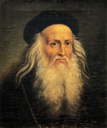

In [6]:
image = Image.open(dest)
image.to_thumb(128,128)

Use `download_images()` to donwload images for the different categories (No Donatello because only waint painters)

In [7]:
painter_categories = "da vinci", "titian", "michaelangelo", "raphael"
path = Path("paintings")

In [8]:
# Remove (will re-create) directory if it already exists
if path.exists():
    print(f"Removing dir: {path}")
    shutil.rmtree(path)

Removing dir: paintings


In [9]:
print(f"creating dir: {path}...")
path.mkdir()
for artist in painter_categories:
    print(f"creating dir for {artist}...")
    dest = (path/artist)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f"{artist} paintings")
    download_images(dest, urls=results)

creating dir: paintings...
creating dir for da vinci...
creating dir for titian...
creating dir for michaelangelo...
creating dir for raphael...


Check that the parent directory contains files:

In [10]:
image_paths = get_image_files(path)

Check for corrupt images:

In [11]:
failed = verify_images(image_paths)
failed

(#11) [Path('paintings/da vinci/0c8b9c94-fb69-4751-98dd-532569a0a272.jpg'),Path('paintings/da vinci/1d540c89-5b83-4e55-841d-b6c10bd6e226.jpg'),Path('paintings/da vinci/fdd3dd64-ba65-4a28-a845-a06cbcaa8ca0.jpg'),Path('paintings/da vinci/c6e9f8af-c6b9-48a8-a100-94f64e9258a5.jpg'),Path('paintings/da vinci/5f8e3073-8053-4476-bef9-842f00adfa34.jpg'),Path('paintings/da vinci/ea6207e4-3bb1-4570-9aa6-b40e59ee3b64.jpg'),Path('paintings/titian/b01a2b31-c922-4cbb-8c7e-c233e9159f1b.jpg'),Path('paintings/titian/ca2f4caa-2a33-471b-8642-ad8f325c0910.JPG'),Path('paintings/michaelangelo/a3d9fe01-df88-476e-8e65-f216619b013f.jpg'),Path('paintings/michaelangelo/cae0224a-c113-4207-98b0-7553b42c3467.jpg')...]

Remove failed images:

In [12]:
# Use semicolon to prevent output
failed.map(Path.unlink);

# Feed data to model

In [13]:
paintings = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dataloaders = paintings.dataloaders(path, verbose=True)

Found 760 items
2 datasets of sizes 608,152
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}


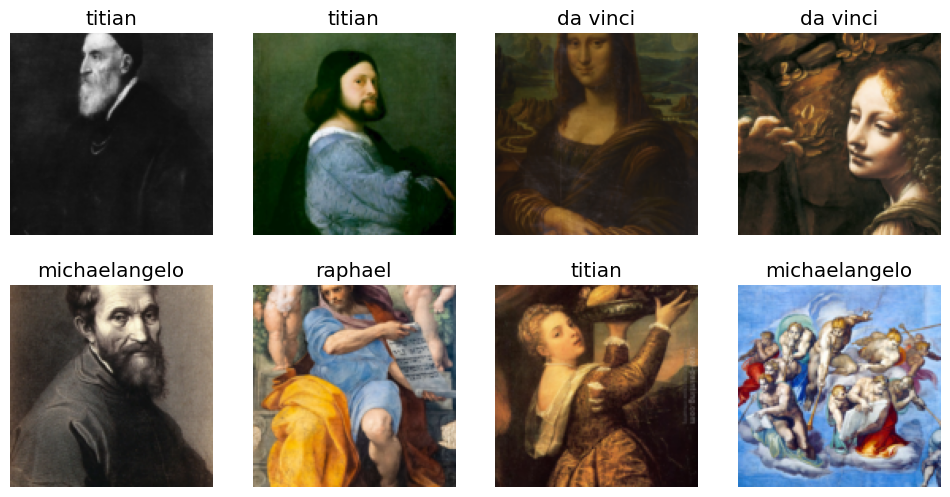

In [15]:
dataloaders.valid.show_batch(max_n=8, nrows=2)

Data augmentation:

In [16]:
paintings = paintings.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dataloaders = paintings.dataloaders(path)

In [37]:
learn = vision_learner(dataloaders, resnet50, metrics=accuracy)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.704640,1.512283,0.625000,00:16


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.913546,0.617856,0.776316,00:17
1,0.700208,0.449585,0.842105,00:17
2,0.537451,0.420544,0.875000,00:17
3,0.449736,0.644788,0.835526,00:16
4,0.373530,0.377661,0.901316,00:17
5,0.308482,0.333469,0.907895,00:15
6,0.260954,0.259849,0.927632,00:18
7,0.214794,0.262651,0.940789,00:17
8,0.183221,0.267147,0.940789,00:17
9,0.158854,0.275072,0.940789,00:17


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

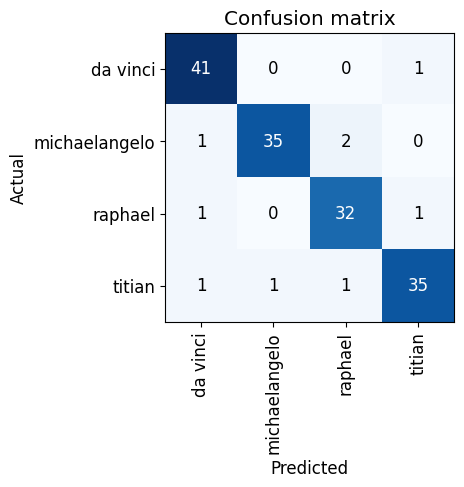

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Higher loss if:
- the model incorrectly predicts, especially if it's highly confident (high probability) in its prediction
- the model correctly predicts, but with low confidence (low probability)

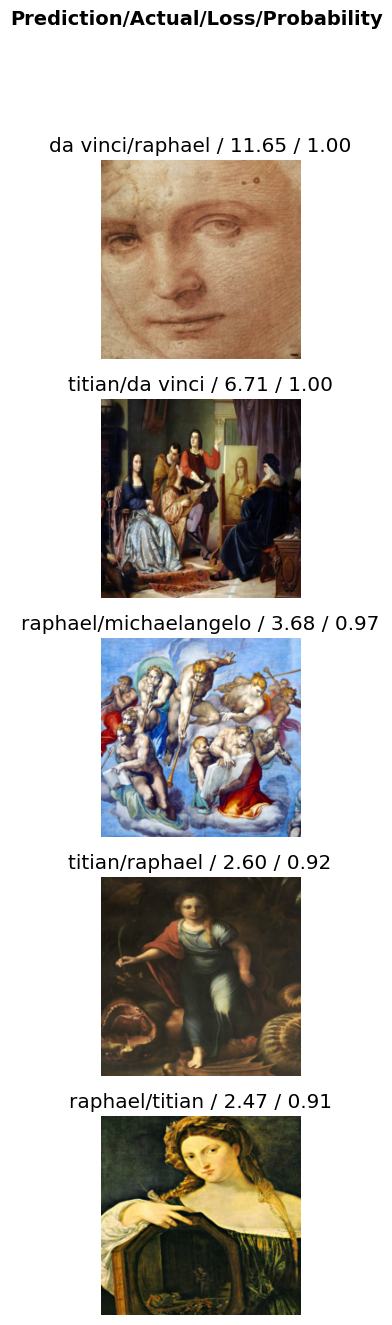

In [39]:
# show 1 per line to prevent text overlapping
interp.plot_top_losses(5, nrows=5)

In [40]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [41]:
for index in cleaner.delete(): cleaner.fns[index].unlink()
for index,category in cleaner.change(): shutil.move(str(cleaner.fns[index]), path/category)

Export model for inference

In [42]:
learn.export()

In [43]:
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]